<a href="https://colab.research.google.com/github/Riddars/BeerProject/blob/main/BeerProject_v_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install fancyimpute
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm import tqdm

from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from fancyimpute import IterativeImputer

In [28]:
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/BearProject/main/recipeData.csv', encoding='ISO-8859-1')

In [29]:
data_df.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


# РАБОТА С ДАТАСЕТОМ
**анализируем выбросы**

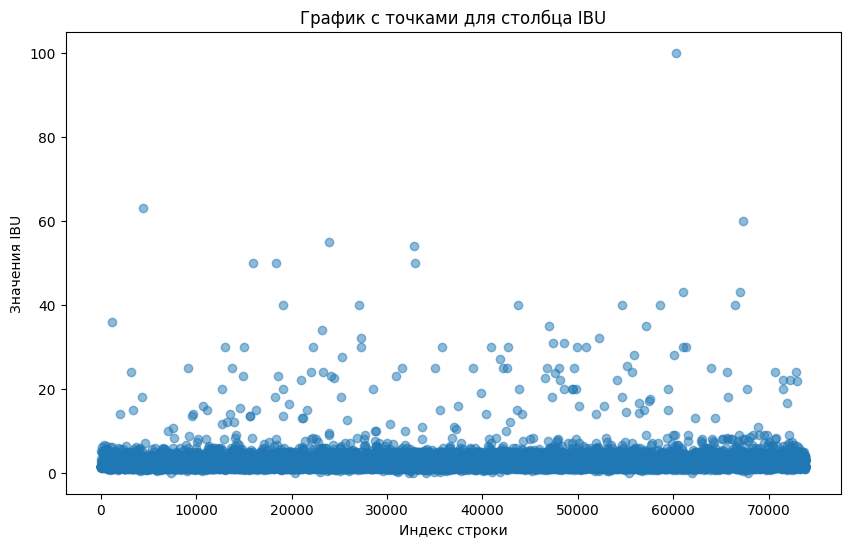

In [30]:
# Замените 'IBU' на имя вашего столбца
ibu_values = data_df['MashThickness']

# Создайте график с точками
plt.figure(figsize=(10, 6))
plt.scatter(range(len(ibu_values)), ibu_values, alpha=0.5)
plt.xlabel('Индекс строки')
plt.ylabel('Значения IBU')
plt.title('График с точками для столбца IBU')
plt.show()

In [31]:
mean_ibu = data_df['IBU'].mean()
variance_ibu = data_df['IBU'].var()

# Выведите результаты
print(f"Среднее значение IBU: {mean_ibu}")
print(f"Дисперсия IBU: {variance_ibu}")

Среднее значение IBU: 44.27618621464642
Дисперсия IBU: 1844.3166280448795


# Удаляем выбросы



---



In [32]:
data_df = data_df[(data_df['IBU'] <= 200) &
                  (data_df['ABV'] <= 10) &
                  (data_df['FG'] <= 5) &
                  (data_df['Size(L)'] <= 2000) &
                  (data_df['BoilSize'] <= 1000) &
                  (data_df['BoilTime'] <= 125) &
                  (data_df['BoilGravity'].le(15) | data_df['BoilGravity'].isnull()) &
                  (data_df['MashThickness'].le(9) | data_df['MashThickness'].isnull())]



----------------



**анализируем разброс данных**

In [33]:
# Замените 'IBU' на имя вашего столбца
ibu_values = data_df['MashThickness']

# Определите интервалы
intervals = [0, 9, 15, float('inf')]  # Диапазоны: 0-100, 100-500, и выше 500

# Создайте гистограмму для подсчета частоты значений в каждом диапазоне
hist, bin_edges = np.histogram(ibu_values, bins=intervals)

# Выведите результаты
for i in range(len(hist)):
    if i == len(hist) - 1:
        print(f'Значения IBU выше {intervals[i]}: {hist[i]}')
    else:
        print(f'Значения IBU в диапазоне {intervals[i]}-{intervals[i + 1]}: {hist[i]}')


Значения IBU в диапазоне 0-9: 41392
Значения IBU в диапазоне 9-15: 12
Значения IBU выше 15: 0




---



---



In [34]:
# Удаляем строки с незаполнеными Style и Name (их не много так что не вдумывайся в смысл)
data_df = data_df.dropna(subset=['Style', 'Name'])

## Заполняем пустые значения с помощью импьютирования

In [35]:
# Список столбцов, которые вы хотите импьютровать
columns_to_impute = ['MashThickness', 'PitchRate', 'PrimaryTemp', 'BoilGravity']  # добавьте другие столбцы при необходимости

# Создание объекта IterativeImputer
mice_imputer = IterativeImputer()

# Применение импьютации к выбранным столбцам
data_df[columns_to_impute] = mice_imputer.fit_transform(data_df[columns_to_impute])

# Проверка эффективности импьютации
for column in columns_to_impute:
    original_mean = data_df[column].mean()
    original_median = data_df[column].median()

    imputed_mean = data_df[column].mean()
    imputed_median = np.median(data_df[column])

    mse = mean_squared_error(data_df[column], data_df[column])

    print(f"Статистика для '{column}' до импьютации:")
    print(f"Среднее значение: {original_mean}")
    print(f"Медиана: {original_median}\n")
    print(f"Статистика для '{column}' после импьутации:")
    print(f"Среднее значение: {imputed_mean}")
    print(f"Медиана: {imputed_median}\n")
    print(f"Среднеквадратичная ошибка (MSE) после импьютации: {mse}\n")

Статистика для 'MashThickness' до импьютации:
Среднее значение: 2.060712501649549
Медиана: 2.0481188573432707

Статистика для 'MashThickness' после импьутации:
Среднее значение: 2.060712501649549
Медиана: 2.0481188573432707

Среднеквадратичная ошибка (MSE) после импьютации: 0.0

Статистика для 'PitchRate' до импьютации:
Среднее значение: 0.736994698170454
Медиана: 0.7368876828305854

Статистика для 'PitchRate' после импьутации:
Среднее значение: 0.736994698170454
Медиана: 0.7368876828305854

Среднеквадратичная ошибка (MSE) после импьютации: 0.0

Статистика для 'PrimaryTemp' до импьютации:
Среднее значение: 19.138235493528185
Медиана: 19.14487797520406

Статистика для 'PrimaryTemp' после импьутации:
Среднее значение: 19.138235493528185
Медиана: 19.14487797520406

Среднеквадратичная ошибка (MSE) после импьютации: 0.0

Статистика для 'BoilGravity' до импьютации:
Среднее значение: 1.2511090306084425
Медиана: 1.047

Статистика для 'BoilGravity' после импьутации:
Среднее значение: 1.25110903



---



---



In [36]:
missing_values = data_df.isnull().sum()
print(missing_values)

BeerID               0
Name                 0
URL                  0
Style                0
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity          0
Efficiency           0
MashThickness        0
SugarScale           0
BrewMethod           0
PitchRate            0
PrimaryTemp          0
PrimingMethod    62878
PrimingAmount    64769
UserId           47197
dtype: int64




---



(69372, 23)


<ipython-input-37-365ad99b258c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_df.corr(), cmap='viridis', yticklabels=True)


<Axes: >

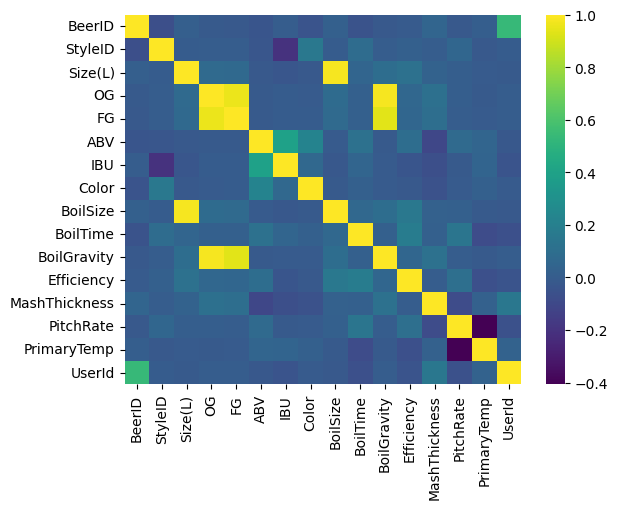

In [37]:
# посмотрим корреляцию столбцов с числовыми значениями
print(data_df.shape)
sns.heatmap(data_df.corr(), cmap='viridis', yticklabels=True)

**Encoding**


---




In [38]:
le = LabelEncoder()
text_data_features = ['SugarScale', 'BrewMethod']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    data_df[i] = le.fit_transform(data_df[i])
    l3.append(list(data_df[i].unique())); l4.append(list(le.inverse_transform(data_df[i].unique())))
    print(i,' : ',data_df[i].unique(),' = ',le.inverse_transform(data_df[i].unique()))

Label Encoder Transformation


100%|██████████| 2/2 [00:00<00:00, 29.05it/s]

SugarScale  :  [1 0]  =  ['Specific Gravity' 'Plato']
BrewMethod  :  [0 3 1 2]  =  ['All Grain' 'extract' 'BIAB' 'Partial Mash']


**Нормализация числовых значений (кроме закодированых)**

---



In [39]:
# Ваши данные и столбцы для нормализации
columns_to_normalize = ['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp']

# Получите минимальные и максимальные значения для каждого столбца до нормализации
min_values_before = data_df[columns_to_normalize].min()
max_values_before = data_df[columns_to_normalize].max()

print("Минимальные значения до нормализации:")
print(min_values_before)

print("Максимальные значения до нормализации:")
print(max_values_before)

Минимальные значения до нормализации:
Size(L)           1.000000
OG                1.000000
FG                0.425441
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          1.000000
BoilTime          0.000000
BoilGravity       0.000000
Efficiency        0.000000
MashThickness     0.000000
PitchRate        -1.288560
PrimaryTemp     -17.780000
dtype: float64
Максимальные значения до нормализации:
Size(L)          1400.00000
OG                 21.63110
FG                  4.99375
ABV                10.00000
IBU               200.00000
Color             186.00000
BoilSize         1000.00000
BoilTime          125.00000
BoilGravity        15.00000
Efficiency        100.00000
MashThickness       9.00000
PitchRate           2.00000
PrimaryTemp       114.00000
dtype: float64


In [40]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69372 entries, 0 to 73860
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BeerID         69372 non-null  int64  
 1   Name           69372 non-null  object 
 2   URL            69372 non-null  object 
 3   Style          69372 non-null  object 
 4   StyleID        69372 non-null  int64  
 5   Size(L)        69372 non-null  float64
 6   OG             69372 non-null  float64
 7   FG             69372 non-null  float64
 8   ABV            69372 non-null  float64
 9   IBU            69372 non-null  float64
 10  Color          69372 non-null  float64
 11  BoilSize       69372 non-null  float64
 12  BoilTime       69372 non-null  int64  
 13  BoilGravity    69372 non-null  float64
 14  Efficiency     69372 non-null  float64
 15  MashThickness  69372 non-null  float64
 16  SugarScale     69372 non-null  int64  
 17  BrewMethod     69372 non-null  int64  
 18  PitchR